<a href="https://colab.research.google.com/github/spirosChv/python-neuro-intro-imbizo2026/blob/main/intro_to_python_imbizo2026_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Networks, Noise, and Functions

### Spiros Chavlis

In Parts 1 and 2, we simulated a single neuron using a script. But the brain consists of billions of connected neurons, and they are never perfectly silent, they are noisy!

In this section, we will:
1.  **Modularize:** Turn our math into Python **Functions** so we can reuse it easily.
2.  **Connect:** Simulate two neurons (Neuron A $\to$ Neuron B).
3.  **Add Noise:** Inject random fluctuations to mimic biological reality.

In [ ]:
# =============================================================================
# 1. Setup and Constants
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
dt = 0.1  # Time step (ms)
T = 200.0  # Duration (ms) - Longer time for this part
num_steps = int(T / dt)

# Neuron Parameters
tau = 20.0  # Membrane time constant (ms)
E_L = -70.0  # Resting potential (mV)
R = 10.0  # Resistance (MOhm)
V_th = -50.0  # Spike Threshold (mV)
V_reset = -65.0  # Reset Potential (mV)

# Synapse Parameters
tau_syn = 5.0  # Synaptic decay (ms)
w = 0.1  # Synaptic weight
E_syn = 0.0  # Excitatory Reversal Potential (0mV)

print("Environment reset. Ready for Part 3.")

Environment reset. Ready for Part 3.


---
## 2. Writing Functions

If we want to simulate 2 neurons, copying and pasting the update equation twice is messy. If we want 100 neurons, it's impossible.

The solution is to wrap our math in a **Function**.
A function takes inputs (Voltage, Current), does the math, and returns the output (New Voltage).

**The Structure:**
```python
def function_name(input1, input2):
    # Do something
    return result

In [ ]:
# =============================================================================
# Defining the LIF Function
# =============================================================================

def update_neuron(V, I, dt):
    """
    Updates the membrane potential for one time step.
    Arguments:
        V: Current Voltage
        I: Input Current
        dt: Time step size
    Returns:
        V_new: The updated Voltage
    """

    # 1. Calculate change (dV/dt)
    # Equation: tau * dV/dt = -(V - E_L) + R*I
    dv_dt = ( -(V - E_L) + R * I ) / tau

    # 2. Euler update
    V_new = V + dv_dt * dt

    return V_new

# Let's test it once to make sure it works
test_V = -70.0
test_I = 1.0
next_V = update_neuron(test_V, test_I, dt)
print(f"If V is -70 mV and I is 1.0, the next V is {next_V} mV")

If V is -70 and I is 1.0, the next V is: -69.95


## 3. Two Neurons and Noise

Now we will simulate two neurons: **Neuron A** and **Neuron B**.

**The Circuit:**
1.  **Neuron A:** Receives random **Noise** input. It will fire randomly.
2.  **Neuron B:** Receives **Synaptic Input** from Neuron A.

**What is Noise?**
Real neurons are bombarded by thousands of tiny inputs we can't track individually. We approximate this using `np.random.normal(mean, std_dev)`, which gives us random numbers from a Gaussian distribution.

In [ ]:
# =============================================================================
# Simulating the Network
# =============================================================================

# Initialize two neurons
V_A = E_L
V_B = E_L

# Initialize Synapse (From A to B)
g_syn_B = 0.0  # Conductance in B, controlled by A

# Storage Lists
trace_V_A = []
trace_V_B = []

print("Starting simulation...")

for i in range(num_steps):

    # NEURON A (The Driver)

    # 1. Generate random noise current for A
    # Mean = 1.5 nA (enough to drive spikes), Noise Level = 1.0
    I_noise = np.random.normal(loc=1.5, scale=1.0)

    # 2. Update Neuron A using our new function!
    V_A = update_neuron(V_A, I_noise, dt)

    # 3. Check for Spike in A
    spike_A = False # Did A spike this step?
    if V_A >= V_th:
        V_A = V_reset
        spike_A = True # Mark that a spike happened


    # SYNAPSE (A -> B)

    # 4. Update Conductance in B
    # Decay
    dg_dt = -g_syn_B / tau_syn
    g_syn_B = g_syn_B + dg_dt * dt

    # If A spiked, kick the conductance up
    if spike_A:
        g_syn_B = g_syn_B + w


    # NEURON B (The Receiver)

    # 5. Calculate Synaptic Current into B
    I_syn = -g_syn_B * (V_B - E_syn)

    # 6. Update Neuron B
    # It only receives synaptic current (no noise)
    V_B = update_neuron(V_B, I_syn, dt)

    # 7. Check for Spike in B (just for resetting)
    if V_B >= V_th:
        V_B = V_reset


    # STORE DATA
    trace_V_A.append(V_A)
    trace_V_B.append(V_B)

print("Simulation complete.")

Starting simulation...
Simulation complete.


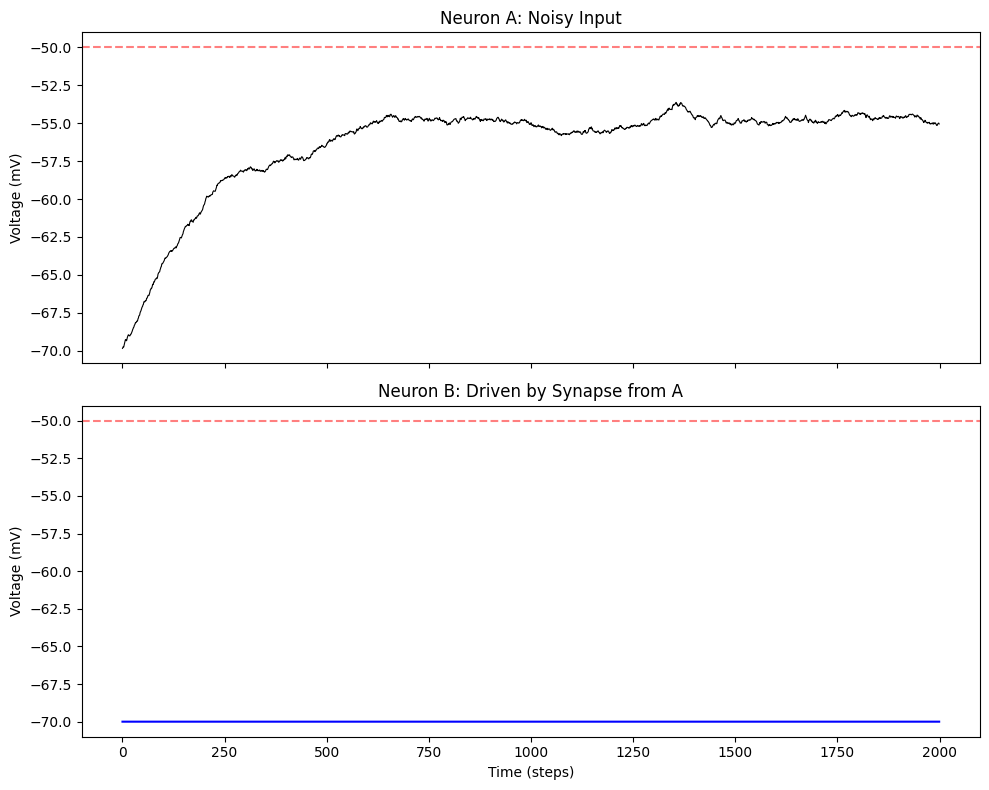

In [ ]:
# =============================================================================
# Plotting the Network Activity
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Neuron A (Noisy Driver)
axes[0].plot(trace_V_A, color='k', linewidth=0.8)
axes[0].set_title('Neuron A: Noisy Input')
axes[0].set_ylabel('Voltage (mV)')
# Add threshold line
axes[0].axhline(y=V_th, color='r', linestyle='--', alpha=0.5)

# Plot Neuron B (Synaptic Receiver)
axes[1].plot(trace_V_B, color='b')
axes[1].set_title('Neuron B: Driven by Synapse from A')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_xlabel('Time (steps)')
axes[1].axhline(y=V_th, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Exercise: Synaptic Strength

In the simulation above, Neuron A fired many times, but Neuron B might have only shown small bumps (EPSPs) without actually firing a spike itself. This means the synapse was "weak".

In learning and memory (Plasticity), the brain strengthens synapses so that one neuron can more easily drive another.

### Your Challenge
1.  Look at your plot for Neuron B. Did it ever cross the red threshold line?
2.  If not, go back to the top of this file.
3.  Increase the Synaptic Weight `w` (try `0.3` or `0.5`).
4.  Re-run the simulation.

**Question:** Can you find the "Critical Weight" where every spike in Neuron A causes a spike in Neuron B?

---
# Conclusion

You have successfully built a computational neuroscience simulation from scratch!

### Summary of what you learned:
1.  **Python Basics:** Variables, Lists, Loops, If-Statements.
2.  **Scientific Python:** Using `NumPy` for math and `Matplotlib` for graphing.
3.  **Modeling:** How to translate biological equations (LIF Model) into code (Euler Method).
4.  **Networks:** How to connect functions together to simulate information flow.

**Where to go next?**
Real brain simulations involve thousands of these neurons connected in complex ways. You can now explore libraries like [**Brian2**](https://brian2.readthedocs.io/en/stable/), [**NEST**](https://nest-simulator.readthedocs.io/en/stable/), or [**Neuron**](https://nrn.readthedocs.io/en/latest/index.html), which do exactly what we did here but optimized for massive scale.

*Happy Coding!*

## 🏠 Homework 3: Hebbian Learning (STDP)

In Part 3, we manually changed the synaptic weight `w`. In the real brain, the synapse changes itself automatically based on the timing of spikes. This is called **Spike-Timing Dependent Plasticity (STDP)** [Bi and Poo, 1998](https://doi.org/10.1523/JNEUROSCI.18-24-10464.1998).

### The Rules
1.  **LTP (Long-Term Potentiation):** If Neuron A (Pre) spikes **before** Neuron B (Post), the connection gets **stronger**. (Causal relationship: A helped B fire).
2.  **LTD (Long-Term Depression):** If Neuron A spikes **after** Neuron B, the connection gets **weaker**. (Anti-causal: A was too late).

### The Algorithm
To simulate this, we need to remember the **Last Spike Time** for both neurons.

* **When Neuron B (Post) spikes:**
    * Check when A last spiked (`t - last_spike_A`).
    * This time difference is positive (A came before B).
    * **Increase** weight: $w \leftarrow w + A_{plus} \cdot \exp(-\Delta t / \tau)$
* **When Neuron A (Pre) spikes:**
    * Check when B last spiked (`t - last_spike_B`).
    * This is the "Post-before-Pre" scenario.
    * **Decrease** weight: $w \leftarrow w - A_{minus} \cdot \exp(-\Delta t / \tau)$

### Your Task
We have set up a simulation where Neuron A and Neuron B fire randomly. Your job is to implement the **Weight Update Rules** inside the loop.

In [ ]:
# =============================================================================
# HOMEWORK: STDP Implementation
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Parameters
dt = 0.1
T = 200.0
num_steps = int(T / dt)

# STDP Parameters
A_plus = 0.01  # Height of LTP curve
A_minus = 0.01  # Height of LTD curve
tau_stdp = 20.0  # Width of the time window (ms)
w_max = 1.0  # Maximum weight limit
w_min = 0.0  # Minimum weight limit

# Initial Weight
w = 0.5
trace_w = []  # To store weight changes

# Spike Times (We will force them to fire at specific times for clarity)
# Neuron A fires at 20, 40, 60...
# Neuron B fires at 25, 45, 65... (A is 5ms BEFORE B -> Should cause LTP)
spikes_A = np.zeros(num_steps)
spikes_B = np.zeros(num_steps)

# Create a pattern where A fires shortly BEFORE B
for t in range(20, int(T-20), 20):
    spikes_A[int(t/dt)] = 1  # A fires
    spikes_B[int((t+5)/dt)] = 1   # B fires 5ms later

# Track the LAST spike time (in ms)
# Initialize to a large negative number (so they haven't fired "recently")
last_spike_A = -1000.0
last_spike_B = -1000.0

print("Simulating STDP...")

for i in range(num_steps):

    current_time = i * dt

    # Check if Neuron A fired this step
    if spikes_A[i] > 0:
        # Update timestamp
        last_spike_A = current_time

        # ---------------------------------------------------
        # YOUR CODE: LTD CHECK
        # Neuron A just fired (Pre). Did B fire recently?
        # If yes, that means B fired BEFORE A. (Post-before-Pre) -> WEAKEN

        # 1. Calculate time difference (delta_t = current_time - last_spike_B)
        # delta_t = ...

        # 2. Apply LTD Rule
        # w = w - A_minus * np.exp(-delta_t / tau_stdp)
        # ---------------------------------------------------

    # Check if Neuron B fired this step
    if spikes_B[i] > 0:
        # Update timestamp
        last_spike_B = current_time

        # ---------------------------------------------------
        # YOUR CODE: LTP CHECK
        # Neuron B just fired (Post). Did A fire recently?
        # If yes, that means A fired BEFORE B. (Pre-before-Post) -> STRENGTHEN

        # 1. Calculate time difference
        # delta_t = ...

        # 2. Apply LTP Rule
        # w = w + A_plus * np.exp(-delta_t / tau_stdp)
        # ---------------------------------------------------

    # Clip the weight so it doesn't go to infinity or negative
    if w > w_max: w = w_max
    if w < w_min: w = w_min

    trace_w.append(w)

# Plotting
plt.plot(trace_w)
plt.title("Synaptic Weight Change (STDP)")
plt.xlabel("Time (steps)")
plt.ylabel("Synaptic Weight (w)")
print("Final Weight:", w)
plt.show()

# QUESTION:
# The weight started at 0.5.
# Since A consistently fires 5ms BEFORE B, did the weight go UP or DOWN?